## Validation & Descriptive Analyses

In this notebook, we run some sanity checks to make sure that the ``Dataset`` class behaves as expected and we also run some descriptive analyses whose results can be used later, e.g., in the accompnaying paper.

In [12]:
import json
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm
from numpy import linalg
from sklearn.metrics import r2_score

from simulation.dataset import Dataset

### Generating a Simulated Dataset 

The first thing to do is to generate a simulated dataset via the ``Dataset`` class. We choose to create one with:
- 10,000 hypothetical responses
- possible score range of $[1, 6]$
- simulated "true" (or gold-standard scores) sampled from $\mathcal{N}(\mu=3.844, \sigma=0.74)$.
- 50 human raters simulated in each of 4 categories with "low" ($\rho=0.4$), "moderate" ($\rho=0.55$), "average" ($\rho=0.65$), and "high" ($\rho=0.8$) inter-rater agreement respectively (total 200 human raters).
- 5 scoring systems simulated in each of 5 categories with "poor" ($R^2=0$), "low" ($R^2=0.4$), "medium" ($R^2=0.65$), "high" ($R^2=0.8$), and "perfect" ($R^2=0.99$) performance respectively (total 25 systems). For all systems $R^2$ is computed against the "true" or gold-standard scores.

These properties can be changed by editing the `dataset.json` file. 

In [13]:
# load the default dataset settings from `dataset.json`
settings = json.load(open('dataset.json', 'r'))

# instantiate a dataset instance from these settings
dataset = Dataset.from_dict(settings)

Next, we populate the dataset by calling the ``generate()`` method which will generate all of the simulated scores. Once this is done, we call the ``to_frames()`` method to get pandas data frames that represent the simulated information in an organized fashion.

In [14]:
# generate the dataset scores
dataset.generate()

# now get the data frames representing this dataset
df_scores, df_rater_metadata, df_system_metadata = dataset.to_frames()

generating true scores ...
generating rater scores and metadata ...
generating system scores and metadata ...


### Distribution of true scores

Let's first check that the distribution of the simulated true scores in the dataset looks as expected.

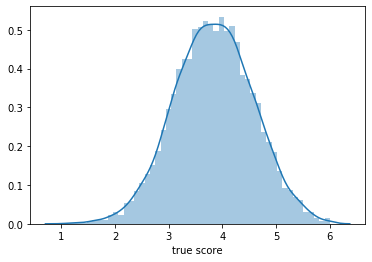

In [15]:
p = sns.distplot(df_scores['true'])
p.set_xlabel('true score')
plt.show()

As expected, the simulated true scores exhibit a normal distribution with the expected mean and standard deviation.

### Relationship between error & inter-rater correlations

Another thing that would be interesting to look at is the effect of the error term (as sampled from $\mathcal{N}(0, \sigma$) on simulater inter-rater correlations as we vary $\sigma$. This is handled by the private method `_find_best_error_sd_for_rho()` of the dataset instance which basically varies $\sigma$ along a line to find the one that simulates the rater scores with average inter-rater correlation closest to the desired value of the given $\rho$. However, this method also returns the values of the inter-rater correlations and $\sigma$ computed as part of the search. So, we can simply plot these two values to see the relationship between them.

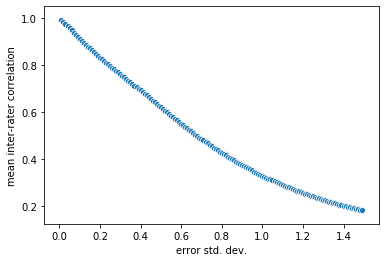

In [16]:
# call the private method - note that the actual value of rho doesn' matter since we are just
# just interested in the error values searched the average inter-rater correlations for the
# corresponding simulated rater scores
error_sds, mean_inter_rater_correlations, _ = dataset._find_best_error_sd_for_rho(0.4, 100)
p = sns.scatterplot(x=error_sds, y=mean_inter_rater_correlations)
p.set_xlabel(r'error std. dev.')
p.set_ylabel('mean inter-rater correlation')
plt.show()

As expected, the average inter-rater correlation monotonically decreases as larger error terms are added to the true scores to simulate the rater scores.

### Inter-rater correlations in each rater category

The next thing we want to check is whether the mean average inter-rater correlations in the 4 simulated human rater categories are actually what we expect them to be. Recall that we wanted four rater categories -  "low" ($\rho=0.4$), "moderate" ($\rho=0.55$), "average" ($\rho=0.65$), and "high" ($\rho=0.8$), each with 50 simulated raters. So, we want to check whether our simulated rhos match these desired rhos.

In [17]:
# the first thing we will do is to compute the correlations between all raters, all systems, and the true scores
# by doing this, we will save a lot of work below by not having to compute the correlations again and again
df_all_correlations = df_scores.corr()

# first we extract all of the columns containing scores from human raters
# these columns all have names of the form `h_X`
rater_columns = [column for column in df_scores.columns if column.startswith('h_')]

# get the correlations between every rater and every other rater and re-organize
# the data frame such that each row corresponds to a pair of raters
df_all_rater_correlations = df_all_correlations.loc[rater_columns, rater_columns]
df_pairwise_rater_correlations = df_all_rater_correlations.unstack().reset_index()
df_pairwise_rater_correlations.columns = ['rater1', 'rater2', 'correlation']

# exclude correlations between the scores from the same rater
different_raters = df_pairwise_rater_correlations['rater1'] != df_pairwise_rater_correlations['rater2']
df_pairwise_rater_correlations = df_pairwise_rater_correlations[different_raters]

# now merge with the categories from the rater metadata data frame; 
# we need to do this twice once for each rater of the pair
df_pairwise_rater_correlations_with_categories = pd.merge(df_pairwise_rater_correlations,
                                                          df_rater_metadata,
                                                          left_on ='rater1',
                                                          right_on='rater_id')
df_pairwise_rater_correlations_with_categories = pd.merge(df_pairwise_rater_correlations_with_categories,
                                                          df_rater_metadata,
                                                          left_on='rater2',
                                                          right_on='rater_id',
                                                          suffixes=['_1', '_2'])

# now trim away any rows where the raters are not in the same cateogry
# since we want to compute within-category mean inter-rater correlations
same_category = df_pairwise_rater_correlations_with_categories['rater_category_1'] == df_pairwise_rater_correlations_with_categories['rater_category_2']
df_pairwise_rater_correlations_same_category = df_pairwise_rater_correlations_with_categories[same_category]

# now group by the category and compute the average correlations
simulated_mean_correlations = df_pairwise_rater_correlations_same_category.groupby('rater_category_1')['correlation'].mean()

# now print out a data frame comparing our simulated values to the values we expected
expected_mean_correlations = pd.Series(dict(zip(dataset.rater_categories, dataset.rater_rho_per_category)))
pd.DataFrame([expected_mean_correlations, simulated_mean_correlations], index=['expected', 'simulated'])

,low,moderate,average,high
expected,0.400000,0.550000,0.650000,0.800000
simulated,0.401045,0.551284,0.648225,0.801706


We can see that our the average within-category inter-rater correlations for our simulated raters are quite close to what we expect. We can also visually compare the distributions of all within-category inter-rater correlations to those of all across-category inter-rater correlations.

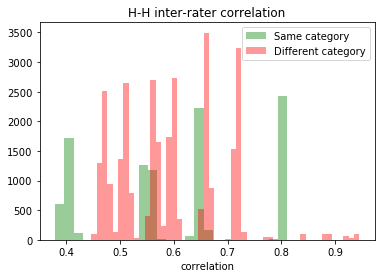

In [18]:
# we already have the within-category inter-rater correlations
# we just need to get the rows that are the opposite - where the two raters are in different categories
different_category = df_pairwise_rater_correlations_with_categories['rater_category_1'] != df_pairwise_rater_correlations_with_categories['rater_category_2']
df_pairwise_rater_correlations_different_category = df_pairwise_rater_correlations_with_categories[different_category]

# plot the distributions of both types of inter-rater correlations
sns.distplot(df_pairwise_rater_correlations_same_category['correlation'], kde=False, color='green', label='Same category')
sns.distplot(df_pairwise_rater_correlations_different_category['correlation'], kde=False, color='red', label='Different category')
plt.title("H-H inter-rater correlation")
plt.legend()
plt.show()

In [19]:
# Finally, let's create a table summarizing various information about rater categories.

df_human_long = df_scores[rater_columns].melt(var_name='rater_id', value_name='score')
df_human_with_metadata = pd.merge(df_human_long, df_rater_metadata)

df_descriptives = df_human_with_metadata.groupby('rater_category')['score'].describe()[['mean', 'std']]
df_descriptives_with_corr = pd.concat([df_descriptives, simulated_mean_correlations], axis=1)

df_descriptives_with_corr['N raters'] = dataset.num_raters_per_category
column_order = ['N raters', 'correlation', 'mean', 'std']
human_rater_description = df_descriptives_with_corr.loc[dataset.rater_categories, column_order]
human_rater_description

,N raters,correlation,mean,std
low,50,0.401045,3.826802,1.136638
moderate,50,0.551284,3.832834,0.988477
average,50,0.648225,3.833874,0.914957
high,50,0.801706,3.833890,0.828453


In [20]:
print(human_rater_description.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
{} &  N raters &  correlation &  mean &  std \\
\midrule
low      &        50 &         0.40 &  3.83 & 1.14 \\
moderate &        50 &         0.55 &  3.83 & 0.99 \\
average  &        50 &         0.65 &  3.83 & 0.91 \\
high     &        50 &         0.80 &  3.83 & 0.83 \\
\bottomrule
\end{tabular}



### Correlation between simulated system performance and true scores

The next thing we want to look at is the correlation between the various automated systems we have simulated in each category and the correlation of these systems' scores with the true scores.

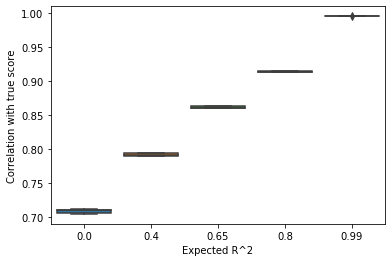

In [21]:
# first we extract all of the columns containing scores from human raters
# these columns all have names of the form `sys_X`; note that we also need
# the true score column
system_columns = [column for column in df_scores.columns if column.startswith('sys_')]

# get the correlations we are interested in
df_system_true_score_correlations = df_all_correlations[system_columns + ['true']]

# extract only the correlations with the true score
df_true_score_correlations = df_system_true_score_correlations['true'].reset_index(name='true_score_correlation')

# now merge these with the system metadata so we can easily make the boxplot we need
df_system_metadata_with_true_score_correlations = pd.merge(df_system_metadata,
                                                           df_true_score_correlations,
                                                           left_on='system_id',
                                                           right_on='index')
# len(df_system_metadata_with_true_score_correlations)
p = sns.boxplot(x='expected_r2_true', y='true_score_correlation', data=df_system_metadata_with_true_score_correlations)
p.set_xlabel('Expected R^2')
p.set_ylabel('Correlation with true score')
plt.show()

As expected, the systems with higher performance are more correlated with the underlying true score.

### RMSE and $R^2$ between system scores and true scores

In a similar vein to the previous analysis, we can also compute the averege $R^2$ and RMSE values between the simulated system scores in each system category and the true scores.

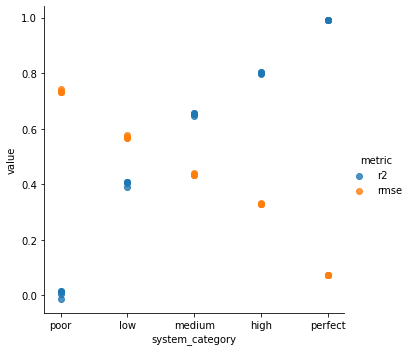

In [22]:
# first let's compute the RMSE between the system scores and the true scores, per system category

# first we extract the scores for each simulated system and the true scores
df_system_and_true_scores = df_scores[system_columns + ['true']]

# next we merge in the system categories 
df_system_and_true_scores = df_system_and_true_scores.melt(id_vars=['true'],
                                                           var_name='system_id',
                                                           value_name='score')

# next we compute the squared error between each simulated system's score for each response and the corresponding true score
df_system_and_true_scores['se'] = (df_system_and_true_scores['true'] - df_system_and_true_scores['score']) ** 2

# finally we compute the RMSE for each system
df_rmse_by_system = df_system_and_true_scores.groupby('system_id')['se'].apply(lambda se: np.sqrt(np.mean(se))).reset_index(name='rmse')

# now let's merge in the categories and plot the RMSE value
df_rmse_by_system_with_categories = df_rmse_by_system.merge(df_system_metadata, left_on='system_id', right_on='system_id')

# next let's compute the R^2 values for each system
df_r2_by_system = df_system_and_true_scores.groupby('system_id').apply(lambda row: r2_score(row['true'], row['score'])).reset_index(name='r2')

# now merge in the r2 and rmse data frames and re-orient it so that we can do a single plot with two metrics
df_rmse_r2_with_categories = df_rmse_by_system_with_categories.merge(df_r2_by_system)
df_rmse_r2_with_categories = df_rmse_r2_with_categories[['system_id', 'r2', 'rmse', 'system_category']].melt(id_vars=['system_id', 'system_category'],
                                                                                                             var_name='metric')

# now plot both the metric values in a single plot
sns.lmplot(x='system_category', y='value', hue='metric', data=df_rmse_r2_with_categories, fit_reg=False)
plt.show()

### Correlations between system scores and rater scores

Next, we want to examine the average correlations between the simulated scores for the systems in each system category and the simulated scores for the raters in each rater category.

In [23]:
# get the correlations between the simulated human rater scores and the simualted system scores
df_system_rater_correlations = df_all_correlations.loc[rater_columns, system_columns]

# now re-orient the data frame so we have pairwise correlations on each row
df_pairwise_system_rater_correlations = df_system_rater_correlations.unstack().reset_index()
df_pairwise_system_rater_correlations.columns = ['system_id', 'rater_id', 'correlation']

# now merge in the rater category and system category labels from the two metadata frames
df_pairwise_system_rater_correlations_with_categories = pd.merge(df_pairwise_system_rater_correlations,
                                                                 df_rater_metadata,
                                                                 left_on='rater_id',
                                                                 right_on='rater_id').merge(df_system_metadata,
                                                                                            right_on='system_id',
                                                                                            left_on='system_id')


# now group the raters and systems by categories and compute 
# the mean correlations for each rater category x each system cateogry
grouper = df_pairwise_system_rater_correlations_with_categories.groupby(['rater_category', 'system_category'])['correlation']
df_mean_system_rater_correlations = grouper.mean().unstack()

# reorder the columns in order of agreement/performance instead of alphabetical
df_mean_system_rater_correlations.loc[dataset.rater_categories, dataset.system_categories]

system_category,poor,low,medium,high,perfect
rater_category,,,,,
low,0.448462,0.501075,0.545229,0.578107,0.629919
moderate,0.526030,0.587710,0.639470,0.678007,0.738710
average,0.570367,0.637270,0.693415,0.735222,0.801093
high,0.631518,0.705556,0.767683,0.813938,0.886787


As we can see, systems that have been simulated to have poor performance actually vary quite a lot in performance depending on the inter-rater correlations of the human raters against which they are being evaluated. This means that correlation is not a very stable metric. We can also see this visually via a boxplot.

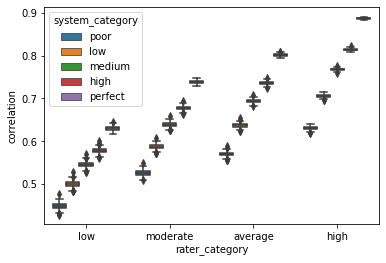

In [24]:
sns.boxplot(x='rater_category', y='correlation', hue='system_category', data=df_pairwise_system_rater_correlations_with_categories)
plt.show()

In [25]:
# Finally, let's make a table that summarizes everything about the systems.

# we first compute average by category for all metrics
df_r2_mean = df_rmse_r2_with_categories.groupby(['system_category', 'metric'])['value'].mean().unstack()
df_corr_average_mean = df_pairwise_system_rater_correlations_with_categories.groupby(['rater_category',
                                                                                  'system_category'])['correlation'].mean().unstack().loc['average'].transpose()
df_corr_true_mean = df_system_metadata_with_true_score_correlations.groupby('system_category')['true_score_correlation'].mean()

# We then combine them together and rename the columns
df_all_systems_mean = pd.concat([df_r2_mean, df_corr_average_mean, df_corr_true_mean], axis=1)
df_all_systems_mean.columns = ['R2 (GS)', 'RMSE (GS)', "r (`average`)", 'r (GS)']
df_all_systems_mean['N systems'] = dataset.num_systems_per_category
system_description = tab_res[['N systems',
               'R2 (GS)',
               'r (GS)', 
               "r (`average`)"]].loc[dataset.system_categories]
system_description

NameError: name 'tab_res' is not defined

In [ ]:
# remove before release
print(system_description.to_latex(float_format='%.2f'))

### Save dataset and frames to disk

Now let's save this dataset instance to disk so that we can reuse it for additional analyses in other notebooks. 
If you want to save your dataset in a standard tabular format, you can use `dataset.save_frames(output_dir)`.

**Note**: The dataset frames are only saved for convenience. Any changes made to these CSV files will _not_ affect any of the analyses in the other notebook since they only use the `.dataset` file.

In [ ]:
# first save the full dataset instance
dataset.save('../data/default.dataset')

# remove before release. We only keep our data in .csv so that the user always has it for reference
# even if they play with the settings
dataset.save_frames('../data')